# Step 0: Basic Definitions + Dataset Analysis
---

In [1]:
import os
import subprocess
import glob
import json
from tqdm import tqdm
from time import monotonic
import pandas as pd
from itertools import islice, cycle
import pathlib
import shutil
import pickle
import random

## CONSTANTS
outputdir = os.path.abspath(os.path.join(os.curdir, 'output'))
barformat = "{bar}{r_bar}| ({percentage:.0f}%) | {desc}"

# Random Seeds
input_primers_random_state = 0
qa_samples_random_state = 0

# Directories
def output(*args):
    return os.path.join(outputdir, *args)

preprocessed_foldername = 'preprocessed'
preprocessed_dir = output(preprocessed_foldername)

# Define External Commands (Scripts)
def runscript(command=[], sibling_folder='tg-server', cwd=os.path.curdir, logfile=None):
    scriptdir=os.path.abspath(os.path.join(os.path.pardir, sibling_folder))
    subprocess.call(command, stdout=logfile, stderr=logfile, cwd=cwd)

# Delete everything inside a folder
def cleardir(dirname):
    print(f'Clearing {dirname}')
    if os.path.exists(dirname): shutil.rmtree(dirname)
    os.mkdir(dirname)

# Prepare Output Data Fields
metriccolumns = ['model', 'checkpoint', 'dataset', 'in_len', 'out_len', 'iteration']
out = []

# primer_length=8
# sample_length=16

iterations = 8        # How many times each experiment should be repeated for the same parameters?
min_input_bars = 1    # What is the minimum lookback size for each model?
min_output_bars = 1   # What is the minimum output size for each model?

max_input_bars = 4    # What is the maximum lookback size for each model?
max_output_bars = 4   # What is the maximum output size for each model?
sample_length = 4     # How long of a final composition should be generated? (Must equal primer_length)
primer_length = 4     # How long should each primer be? (in bars)
repeat_primers = True # Allow primer repetition? (useful for large primer lengths, when primer set becomes small)

max_primers = 10      # How many dataset samples should be used as primers for sequence

# generation_path = '2021-08-17-0'


skip_dataset_preprocessing = False






### Script Testing Overrides

To test with fewer samples/iterations/lengths.
Uncomment when running a final analysis

In [2]:

max_primers = 3      # How many dataset samples should be used as primers for sequence
iterations = 1       # How many times each experiment should be repeated for the same parameters?

skip_dataset_preprocessing = True

### Extract basic dataset metrics

In [3]:
import pandas as pd
import argparse
import os 
import mido

dataset_columns = ['dataset', 'file', 'bpm', 'ticks', 'tpb', 'error']

def get_dataset_metrics(filename):
  try:
    # tqdm.write(filename)
    mid = mido.MidiFile(filename)
    tempo = [msg.tempo for msg in mid if msg.type == 'set_tempo']
    tempo = tempo[0] if any(tempo) else 500000
    bpm = mido.tempo2bpm(tempo)
    tpb = mid.ticks_per_beat
    total_time = sum(mido.second2tick(msg.time, tempo=tempo, ticks_per_beat=tpb) for msg in mid if not msg.is_meta)
    
    return [bpm, total_time, tpb, False]
  except Exception as e:
    # print(f'error with: {filename}')
    # print(e)
    return [0, 0, True]

if not skip_dataset_preprocessing:
  datasets = os.listdir('dataset')
  datasets = [d for d in datasets if d.startswith('clean_')]
  files = tqdm([(dataset, filename)
    for dataset in datasets
    for filename in os.listdir(f'dataset/{dataset}') # [:2]
    if any([filename.endswith(ext) for ext in ['.mid', '.midi']]) ])
    
  # Create DataFrame
  files = [[dataset, filename] + get_dataset_metrics(f'dataset/{dataset}/{filename}')
    for dataset, filename in files]
  df_datasets = pd.DataFrame(files, columns=dataset_columns)

  # Calculate sample bar length
  df_datasets['beats'] = df_datasets['ticks'].astype(int) / df_datasets['tpb'].astype(int)
  df_datasets['bars'] = df_datasets['beats'].astype(float).round() / 4

  print(df_datasets.head())
  if True in df_datasets['error'].unique():
      errloc = df_datasets.loc[df_datasets['error'] == True]
      print(f"{len(errloc.values.tolist())} errors found during dataset analysis")
      print(errloc)

  df_datasets.to_pickle('output/df_dataset_features')

# Step 1: Generation Phase
---

## Definitions

In [4]:

import os
import sys
import subprocess
import pandas as pd
from datetime import date

outputdir = os.path.join(os.path.curdir, 'output')
env = os.environ.copy()

home_dir = os.path.expanduser('~')

# Directories to mount on docker call
ORNETTE_PATH    = env['ORNETTE_PATH']    if 'ORNETTE_PATH'    in env.keys() else os.path.join(home_dir, 'git', 'tg-server')
CHECKPOINT_PATH = env['CHECKPOINT_PATH'] if 'CHECKPOINT_PATH' in env.keys() else os.path.join(home_dir, '.ornette', 'checkpoints')
OUTPUT_PATH     = env['OUTPUT_PATH']     if 'OUTPUT_PATH'     in env.keys() else os.path.join(ORNETTE_PATH, 'output')
DATASET_PATH    = env['DATASET_PATH']    if 'DATASET_PATH'    in env.keys() else os.path.join(ORNETTE_PATH, 'dataset')

barcount = 16

def checkpath(modelname, checkpointname):
    dirname = output('baseline', modelname, checkpointname)
    if not os.path.exists(dirname): os.mkdir(dirname)

ornette_docker_call = (
    [ 'docker' , 'run'
    , '-v'     , f'{CHECKPOINT_PATH}:/checkpoints'
    , '-v'     , f'{OUTPUT_PATH}:/output'
    , '-v'     , f'{DATASET_PATH}:/dataset'
    ]
)

# Generation Output Directory
generation_path = str(date.today())
generation_index = list(folder.split('-')[-1] for folder in os.listdir(output('')) if folder.startswith(generation_path))
generation_index = [int(index) for index in generation_index if index]
generation_index = max(generation_index) + 1 if any(map(str, generation_index)) else 0
generation_path += f'-{generation_index}'
os.mkdir(output(generation_path))

## Ornette Sample Generation Code

In [5]:
# Get Args, define evaluation groups

ignore = (            # What models to ignore during generation/analysis
  [ ''
  # FIXME: These are temporary - shit went wrong
  # , 'rl_duet'            
  # , 'pianoroll_rnn_nade'
  # , 'polyphony_rnn'
  # , 'melody_rnn'
  # , 'performance_rnn'
  ] 
)

# Evaluated Model Table
eval_columns = (
    ['model'               , 'dataset'       , 'output_tracks' , 'checkpoint']
)
eval_list = (
  [ ['performance_rnn'     , 'clean_piano-e-comp'  , None            , 'performance_with_dynamics']
  # , ['performance_rnn'     , 'clean_piano-e-comp'  , None            , 'density_conditioned_performance_with_dynamics']
  # , ['performance_rnn'     , 'clean_piano-e-comp'  , None            , 'pitch_conditioned_performance_with_dynamics']
  # , ['performance_rnn'     , 'clean_piano-e-comp'  , None            , 'multiconditioned_performance_with_dynamics']
  # , ['performance_rnn'     , 'clean_piano-e-comp'  , None            , 'performance_with_dynamics_and_modulo_encoding']
  # , ['rl_duet'             , 'clean_bach10'        , None            , 'rl_duet']
  # , ['melody_rnn'          , 'clean_mtd-orig'      , None            , 'basic_rnn']
  # , ['melody_rnn'          , 'clean_mtd-orig'      , None            , 'mono_rnn']
  , ['melody_rnn'          , 'clean_mtd-orig'      , None            , 'attention_rnn']
  # , ['melody_rnn'          , 'clean_mtd-orig'      , None            , 'lookback_rnn']
  , ['polyphony_rnn'       , 'clean_bach10'        , None            , 'polyphony_rnn']
  , ['pianoroll_rnn_nade'  , 'clean_bach10'        , None            , 'rnn-nade_attn']
#   , ['music_transformer'   , 'piano-e-comp'  , None            , 'performance_with_dynamics']
  ]
)
eval_list = pd.DataFrame(eval_list, columns=eval_columns)

# Filter ignored models
for ignored_model in ignore:
  eval_list = eval_list[eval_list['model'] != ignored_model]

# Index table with dataset names
evaluation_sets = [
  (dataset, [ (modelname, checkpoint, output_tracks)
    for [modelname, checkpoint, output_tracks]
    in inner_df[['model', 'checkpoint', 'output_tracks']].values 
  ])
  for dataset, inner_df in eval_list.groupby(['dataset'])
]

cols_gen = [ "model", "checkpoint", "dataset", "primer", "iteration", "out_file", "time", "in_len", "out_len" ]

In [6]:
# Generation Methods

from functools import reduce
import re
import math

# Prepare a command string to send to ornette via CLI
def escape_command(commands):
  commands = re.split('\n|;', commands)
  commands = [line.split(' ') for line in commands]
  commands = [cmd for cmd in commands if any(cmd)]
  commands = ['\ '.join(line) for line in commands]
  commands = '\;'.join(commands)
  return commands

def get_filename(modelname, checkpointname, primer, index, bars_input, bars_output):
  return f'{generation_path}/{modelname}-{checkpointname}-{index}-{bars_input}-{bars_output}-{primer}'

# WIP: another approach, via CLI args
def get_generation_command(the_modelname, the_checkpointname, output_tracks, datapath, primer, bars_input, bars_output, count):
  total_song_barcount = bars_input + sample_length
  gen_steps = math.ceil(sample_length / bars_output)
  
  # Main generation loop
  exec_cmd = ';\n'.join([f'generate {bars_output} bars' for i in range(gen_steps) ])

  # Reset, load the primer again, generate, save
  exec_cmd = [';\n'.join(
      [ 'reset'
      , f'load /{datapath}/{primer} {bars_input}'
      , exec_cmd
      , f'drop_primer'
      , f'crop bars 0 {total_song_barcount}'
      , f'save {get_filename(the_modelname, the_checkpointname, primer, index, bars_input, bars_output)}'
      # , 'end'
      ]
    )
    for index
    in range(count)]
  
  # Before running generation: set variables
  exec_vars = [ 'set debug_output True;'
    , 'set batch_mode True;'
    , 'set playback False;'
    # , 'set trigger_generate 1;'
    , 'set batch_unit measures;'
    , 'set debug_output False;'
    , f'set input_length {bars_input};'
    , f'set input_unit bars;'
    , f'set output_length {bars_output};'
    , f'set output_unit bars;'
  ]

  if output_tracks: exec_vars.append('set output_tracks ' + output_tracks + ';')

  # Combine Lines
  exec_cmd = '\n'.join(exec_vars + exec_cmd + ['end'])

  # Escape string to pass it via CLI
  exec_cmd = escape_command(exec_cmd)
  return exec_cmd

logfile = None
def generate_samples(the_modelname, the_checkpointname, output_tracks, datapath, primer, bars_input, bars_output, count, t):
    customprint = t.set_description if t else log
    # Set logging prefix
    modelname = the_modelname
    checkpointname = the_checkpointname
    t.set_description(f'Generating ({modelname}:{checkpointname}) samples with {primer}')

    # Get Ornette CLI command
    if datapath.startswith('.'): datapath = datapath[1:]
    cmd = get_generation_command(the_modelname, the_checkpointname, output_tracks, datapath, primer, bars_input, bars_output, count)

    # Process filenames
    filenames = [get_filename(the_modelname, the_checkpointname, primer, index, bars_input, bars_output) for index in range(count)]


    # Run (and time) the generation batch
    logfilename = output(f'{the_modelname}-{the_checkpointname}.log')
    logfile = open(logfilename, 'a')

    start_time = monotonic()
    server = subprocess.run(
      ['python' , '.' , '--modelname' , modelname , '--checkpoint' , checkpoint , '--exec' , cmd , '--no-server=True']
      , env=env
      , stdout=logfile
      , stderr=logfile
      )
    end_time = monotonic()
    
    # Calculate total generation time
    gentime = end_time - start_time
    return [(filenames, gentime)]

def run_generation(model, checkpoint, datapath, primers, output_tracks):
  logfilename = output(f'{model}-{checkpoint}.log')
  with open(logfilename,'w') as logfile:
    print('\n', file=logfile)
  
    t = tqdm(([ model, checkpoint, dataset, primer
        , iterations # TODO: pass iterations to generate samples / use iterations here
        , filename, gentime, bars_input, bars_output]
    for bars_input in range(min_input_bars,max_input_bars + 1)
    for bars_output in range(min_output_bars,max_output_bars + 1)
    for primer in primers
    for (filenames, gentime) in generate_samples(model, checkpoint, output_tracks, datapath, primer, bars_input, bars_output, iterations, t)
    for filename in filenames),
    bar_format=barformat)
  
  return list(t)


### Generate Samples

In [7]:
df_datasets = pd.read_pickle('output/df_dataset_features')

def get_primers(dataset, count):
    print(f'{dataset}:{count}')
    minimum_length = primer_length # NOTE: Setting this too high may remove all samples from the input data. 4 is an ideal value
    # minimum_length += 3
    df_tmp = df_datasets.loc[(df_datasets['bars'] >= minimum_length) & (df_datasets['dataset'] == dataset)].sample(count, random_state=input_primers_random_state, replace=repeat_primers)
    df_tmp['path'] = 'dataset/' + df_tmp['dataset'].astype(str) + '/' + df_tmp['file'].astype(str)
    # df_tmp['path'] = df_tmp[['dataset', 'file']].apply(lambda row: os.path.join('dataset', *row))
    return df_tmp['path'].values


try:
    tqdm.write(f'Starting experiment suite: {outputdir}/{generation_path}')

    # Set logging prefix
    output_rows = []
    for dataset, models in evaluation_sets:
        if dataset is None: continue
        datapath = os.path.join('dataset', dataset)
        # primerdir = datapath
        if not os.path.exists(datapath):
            print(f'Directory not found: {datapath}, skipping')
            continue

        # Select primers from dataset
        primers = get_primers(dataset, max_primers)
        print(primers)

        # Run a generation batch with the chosen samples
        for (model, checkpoint, output_tracks) in models:
            expname = model
            e = run_generation(model, checkpoint, datapath, primers, output_tracks)
            output_rows += e

    # Create DataFrame
    df = pd.DataFrame(output_rows, columns=cols_gen)
    # df.to_pickle(output('df_gen'))
    

except KeyboardInterrupt:
  tqdm.write("Terminating...")

tqdm.write("Done!")

SyntaxError: invalid syntax (<ipython-input-7-fd102f54bc24>, line 30)

### Filter Generated Output

The cell below removes from the dataframe the data about models that had issues with generation. It notifies what model:checkpoints are being removed.

If this happens, check the .log file for more information, there will probably be a python exception somewhere.

In [7]:

# Filter Data
import pandas as pd
from os import path
df_gen = pd.read_pickle('output/df_gen')
df_gen.to_pickle(output('df_gen_bk'))

# Get Models
def get_models(df_):
    df_['uniquename'] = df_['model'] + ':' + df_['checkpoint']
    uniques = [x for x in df_['uniquename'].unique()]
    return uniques

# Only where an output file exists
df_success = df_gen[df_gen.apply(lambda x: os.path.exists(f'output/{x["out_file"]}'),axis=1)]

# print(newdf)
err = [name for name
  in get_models(df_gen)
  if name not in get_models(df_success)
  ]

if any(err):
    df_success.to_pickle(output('df_gen'))
    print(f'The following models had problems at generation time and will not be analysed: {", ".join(err)}')
else:
  print("DataFrame checked!")

DataFrame checked!


## Baseline Sample Generation Code

In [8]:
# Generation Scripts

## Magenta Models

### MelodyRNN: Generate samples
melody_rnn_cmd = lambda checkpoint, primer, barcount, number_of_samples: (
    ornette_docker_call + 
    [ '-t'    , 'ornette/melody_rnn'
    , 'melody_rnn_generate'
    , f'--config={checkpoint}'
    , f'--bundle_file=/checkpoints/melody_rnn/{checkpoint}'
    , f'--output_dir=/output/{generation_path}/baseline/melody_rnn/{checkpoint}'
    , f'--num_outputs={number_of_samples}'
    , f'--num_steps={(sample_length + primer_length) * 4 * 4}'
    , f'--primer_midi={primer}'
    ]
)

### PerformanceRNN: Generate samples
performance_rnn_cmd = lambda checkpoint, primer, barcount, number_of_samples: (
    ornette_docker_call + 
    [ '-t'    , 'ornette/performance_rnn'
    , 'performance_rnn_generate'
    , f'--config={checkpoint}'
    , f'--bundle_file=/checkpoints/performance_rnn/{checkpoint}'
    , f'--output_dir=/output/{generation_path}/baseline/performance_rnn/{checkpoint}'
    , f'--num_outputs={number_of_samples}'
    , f'--num_steps={(sample_length + primer_length) * 2 * 100}'
    , f'--primer_midi={primer}'
    ]
)

### PianorollRNN-NADE: Generate Samples
pianoroll_rnn_nade_cmd = lambda checkpoint, primer, barcount, number_of_samples: (
    ornette_docker_call + 
    [ '-t'    , 'ornette/pianoroll_rnn_nade'
    , 'pianoroll_rnn_nade_generate'
    , f'--config=rnn-nade_attn'
    , f'--bundle_file=/checkpoints/pianoroll_rnn_nade/{checkpoint}'
    , f'--output_dir=/output/{generation_path}/baseline/pianoroll_rnn_nade/{checkpoint}'
    , f'--num_outputs={number_of_samples}'
    , f'--num_steps={(sample_length + primer_length) * 4 * 4}'
    , f'--primer_midi={primer}'
    ]
)   

### PolyphonyRNN: Generate Samples
polyphony_rnn_cmd = lambda checkpoint, primer, barcount, number_of_samples: (
    ornette_docker_call + 
    [ '-t'    , 'ornette/polyphony_rnn'
    , 'polyphony_rnn_generate'
    , f'--config=rnn-nade_attn'
    , f'--bundle_file=/checkpoints/polyphony_rnn/{checkpoint}'
    , f'--output_dir=/output/{generation_path}/baseline/polyphony_rnn/{checkpoint}'
    , f'--num_outputs={number_of_samples}'
    , f'--num_steps={(sample_length + primer_length) * 4 * 4}'
    , '--condition_on_primer=true'
    , '--inject_primer_during_generation=false'
    , f'--primer_midi={primer}'
    ]
)

# List of generation scripts
baseline_generation_commands = {
    'melody_rnn': melody_rnn_cmd,
    'performance_rnn': performance_rnn_cmd,
    'pianoroll_rnn_nade': pianoroll_rnn_nade_cmd,
    'polyphony_rnn': polyphony_rnn_cmd,
}

# Crop a midi file (via ornette)
cmd_crop = lambda input_file, output_file, _length: (
    ['python'
    , '.'
    , '--no-server'
    , 'true'
    , '--no-module'
    , 'true'
    , '--modelname'
    , 'melody_rnn'
    , '--checkpoint'
    , 'basic_rnn'
    , '--exec'
    , '\;'.join(
        [ 'reset'
        , f'load\ {input_file}\ 8000'
        , f'crop\ bars\ 0\ {_length}'
        , f'save\ {output_file}'
        , 'end'
        ])
    ]
)

In [9]:
# Read generation data
df_gen = pd.read_pickle(output('df_gen'))
df_gen.loc[df_gen['model'] == 'melody_rnn', 'dataset'] = 'mtd-orig'

# Determine how many samples to generate
number_of_samples = df_gen.groupby(['model', 'checkpoint', 'in_len', 'out_len', 'dataset', 'iteration']).count().reset_index()['primer'].max()
# number_of_samples = df_gen.groupby(['model', 'checkpoint', 'dataset', 'iteration']).count().reset_index()['primer'].max()
number_of_samples = int(number_of_samples / len(df_gen['in_len'].unique()))
number_of_samples = int(number_of_samples / len(df_gen['out_len'].unique()))
df_gen = df_gen.drop(columns=['out_file','time','in_len','out_len'])


# Clear 'tmp' folder
tmp_foldername = 'tmp_baseline'
models = df_gen['model'].unique()
print(f'Generating baseline samples for: {models}')
cleardir(output(tmp_foldername))
cleardir(output('baseline'))

# Create iterator
df_gen = df_gen.groupby(['model', 'checkpoint', 'dataset', 'primer']).count().reset_index()
#df_iterator = df_gen.iterrows()
df_iterator = tqdm(df_gen.values.tolist(), bar_format=barformat)

logfile = open(output('baseline.log'), 'w')

# Baseline Sample Generation Loop
for row in df_iterator:

    model = row[0]
    checkpoint = row[1]
    dataset = row[2]
    primer = row[3]
    
    try:
        baseline_generation_command = baseline_generation_commands[model]
    except KeyError:
        df_iterator.set_description(f'{model}:{checkpoint} has no baseline model. Skipping...')
        continue
    
    df_iterator.set_description(f'{model}:{checkpoint} ({primer})')

    print(f'Starting generation of baseline samples for {model}:{checkpoint}\n', file=logfile)

    # Crop Dataset Samples (/dataset -> /output/tmp_baseline)
    outputpath = output(tmp_foldername, primer)
    if not os.path.exists(outputpath):
        extless = primer.split('.')[:-1]
        extless = '.'.join(extless)
        dataset_samplepath = f'/dataset/{dataset}/{primer}' # Directory is inside container
        dataset_outputpath = f'{tmp_foldername}/{extless}'  # Directory is inside container
        command = cmd_crop(dataset_samplepath, dataset_outputpath, primer_length)
        subprocess.call(command, stdout=logfile, stderr=logfile, cwd=ORNETTE_PATH)

    , 'true'
    , '--modelname'
    , 'melody_rnn'

    

    # Generate Baseline Samples (/tmp_baseline -> /output/baseline/<model>/<checkpoint>)
    command = baseline_generation_command
    primer_path = f'/output/{tmp_foldername}/{primer}'      # Directory is inside container
    command = command(checkpoint, primer_path, barcount, number_of_samples)
    subprocess.call(command, stdout=logfile, stderr=logfile)

logfile.close()

          | 0/10 [00:00<?, ?it/s]| (0%) | performance_rnn:performance_with_dynamics (MIDI-Unprocessed_03_R1_2008_01-04_ORIG_MID--AUDIO_03_R1_2008_wav--1.midi): Generating baseline samples for: ['performance_rnn']
Clearing ./output/tmp_baseline
Clearing ./output/baseline
██████████| 10/10 [01:38<00:00,  9.82s/it]| (100%) | performance_rnn:performance_with_dynamics (ORIG-MIDI_01_7_7_13_Group__MID--AUDIO_12_R1_2013_wav--4.midi): 


# Step 2: Feature Extraction

## Preprocess Samples

In [10]:

# Declare analysis script
metricsfile = output('metrics_gen')
extraction_scriptdir = os.path.abspath(os.path.join(os.path.pardir, 'mgeval'))
extraction_script = os.path.join(extraction_scriptdir, 'start.sh')
cmd_extraction = lambda dataset_1, dataset_2, output_pickle_filename: [
    'bash',
    extraction_script,
    os.path.abspath(dataset_1),
    os.path.abspath(dataset_2),
    output_pickle_filename,
    str(sample_length)
]

In [11]:
# Declare Preprocessing Script
preprocess_scriptdir = os.path.abspath(os.path.join(os.path.pardir, 'miditools'))
preprocess_script = os.path.join(preprocess_scriptdir, 'midisox_py')
cmd_preprocess = lambda _in, _out: [ 'python', preprocess_script, '-m', os.path.abspath(_in), os.path.abspath(_out) ]

crop_sample = lambda filename: subprocess.call(cmd_crop(filename, filename, sample_length), stdout=logfile, stderr=logfile)

# Load data to preprocess
df_gen = pd.read_pickle(output('df_gen'))
gen_cols = ['model', 'checkpoint', 'in_len', 'out_len', 'dataset', 'iteration', 'out_file']
#grouping = df_gen.groupby(gen_cols)

# Prepare outputs
logfile = open(output('preprocess.log'), 'w')
skip_preprocessing = [ None
    # , 'baseline'
    # , 'dataset'
    # , 'generation'
    ][1:]
if not any(skip_preprocessing): cleardir(preprocessed_dir)

# Preprocess Dataset Samples
def get_dataset_samples(dataset_name, how_many):
    dataset_samples = os.listdir(os.path.join(os.path.curdir, 'dataset', dataset_name)) # Get all files in dataset folder
    dataset_samples = islice(cycle(dataset_samples), how_many)
    return list(enumerate(dataset_samples))                                             # Get exactly that same count, repeating if necessary


number_of_samples = df_gen.groupby(['model', 'checkpoint', 'in_len', 'out_len', 'dataset', 'iteration']).count().reset_index()['primer'].max()
number_of_samples /= len(df_gen['in_len'].unique())
number_of_samples /= len(df_gen['out_len'].unique())
number_of_samples = int(number_of_samples)
dataset_files = [(dataset_name, index, filename)
  for dataset_name in df_gen['dataset'].unique()
  for (index, filename) in get_dataset_samples(dataset_name, number_of_samples)]
iterator = tqdm(dataset_files, bar_format=barformat)

if 'dataset' not in skip_preprocessing:
    os.mkdir(output(preprocessed_foldername, 'dataset'))
    for dataset, index, filename in iterator:
        # Create Output Folder
        in_filename = os.path.join('dataset', dataset, filename)
        iterator.set_description(f'Preprocessing {dataset}/{filename}')
        out_dir = output(preprocessed_foldername, 'dataset', dataset)
        if not os.path.exists(out_dir): os.mkdir(out_dir)
        out_filename = output(preprocessed_foldername, 'dataset', dataset, str(index) + '-' + filename.split('/')[-1])
        subprocess.call(cmd_preprocess(in_filename, out_filename), stdout=logfile, stderr=logfile, cwd=preprocess_scriptdir)

    # Crop samples
    for dataset in os.listdir(output(preprocessed_foldername, 'dataset')):
        for filename in os.listdir(output(preprocessed_foldername, 'dataset', dataset)):
            crop_sample(f'/output/{preprocessed_foldername}/dataset/{dataset}/{filename}')




# Preprocess Baseline Samples
if 'baseline' not in skip_preprocessing:
    os.mkdir(output(preprocessed_foldername, 'baseline'))
    baseline_list = [(model, checkpoint, samplename)
        for (model, checkpoint) in df_gen.groupby(['model', 'checkpoint']).groups
        for samplename in os.listdir(output(generation_path, 'baseline', model, checkpoint))]
    iterator = tqdm(baseline_list, bar_format=barformat)
    for model, checkpoint, samplename in iterator:
        in_filename = output(generation_path, 'baseline', model, checkpoint, samplename)
        out_filename = output(preprocessed_foldername, 'baseline', model, checkpoint, samplename)
        iterator.set_description(f'Preprocessing baseline sample: {in_filename}')
        if not os.path.exists(in_filename):
            # iterator.set_description(f'No Input')
            tqdm.write(f'No Input: {in_filename}')
            continue
        
        # Create Output Folder
        out_path = output(preprocessed_foldername, 'baseline', model, checkpoint)
        pathlib.Path(out_path).mkdir(parents=True, exist_ok=True)

        # Preprocess sample
        subprocess.call(cmd_preprocess(in_filename, out_filename), stdout=logfile, stderr=logfile, cwd=preprocess_scriptdir)

        # Crop sample
        crop_sample(f'/output/{preprocessed_foldername}/baseline/{model}/{checkpoint}/{samplename}')


# Preprocess Generated Output
if 'generated' not in skip_preprocessing:
    df_gen['out_file_prep'] = df_gen[gen_cols].apply(lambda row: ':'.join(row.values.astype(str)), axis=1)
    generation_list = df_gen[gen_cols + ['out_file_prep', 'primer']].drop_duplicates().values.tolist()
    iterator = tqdm(generation_list, bar_format=barformat)
    for (model, checkpoint, in_len, out_len, dataset, iteration, out_file, out_file_prep, primer) in iterator:
        in_filename = output(out_file)
        out_filename = output(preprocessed_foldername, 'generation', out_file_prep)
        out_path = '/'.join(out_filename.split('/')[:-1])
        iterator.set_description(f'Preprocessing generated sample: {out_filename}')

        # Create Output Folder
        pathlib.Path(out_path).mkdir(parents=True, exist_ok=True)

        # Preprocess sample
        # in_filename += '.mid'
        subprocess.call(cmd_preprocess(in_filename, out_filename), stdout=logfile, stderr=logfile, cwd=preprocess_scriptdir)

        # Crop sample
        crop_sample(f'/output/{preprocessed_foldername}/generation/{out_file_prep}')

    # Save preprocessed data info
    df_gen.to_pickle(output('df_gen'))
logfile.close()

          | 0/5 [00:00<?, ?it/s]| (0%) | Preprocessing clean_piano-e-comp/MIDI-Unprocessed_R1_D2-13-20_mid--AUDIO-from_mp3_19_R1_2015_wav--4.midi: Clearing /home/ghales/git/tg-server/output/preprocessed
██████████| 5/5 [00:04<00:00,  1.03it/s]| (100%) | Preprocessing clean_piano-e-comp/ORIG-MIDI_01_7_7_13_Group__MID--AUDIO_12_R1_2013_wav--4.midi: 
          | 0/0 [00:00<?, ?it/s]| (0%) | 
██████████| 1280/1280 [17:24<00:00,  1.23it/s]| (100%) | Preprocessing generated sample: ./output/preprocessed/generation/performance_rnn:performance_with_dynamics:4:4:clean_piano-e-comp:8:2021-08-27-2/performance_rnn-performance_with_dynamics-7-4-4-MIDI-Unprocessed_065_PIANO065_MID--AUDIO-split_07-07-17_Piano-e_3-01_wav--3.midi: 


In [4]:

# Declare analysis script
metricsfile = output('metrics_gen')
extraction_scriptdir = os.path.abspath(os.path.join(os.path.pardir, 'mgeval'))
extraction_script = os.path.join(extraction_scriptdir, 'start.sh')
cmd_extraction = lambda dataset_1, dataset_2, output_pickle_filename: [
    'bash',
    extraction_script,
    os.path.abspath(dataset_1),
    os.path.abspath(dataset_2),
    output_pickle_filename,
    str(sample_length)
]

## Extract Features from Samples

In [8]:
metriccolumns = ['model', 'checkpoint', 'dataset', 'in_len', 'out_len', 'iteration']

# Prepare output
if os.path.exists(metricsfile): os.remove(metricsfile)
logfile = open(output('extraction.log'), 'w')

# Extract metrics between two different datasets
print('Extracting metrics from generated output', file=logfile)
def extract_metrics(samples_path, dataset_path, logfile, iterator):
    iterator.set_description(f'Analyzing samples inside: {samples_path}')
 
    # Extract features
    subprocess.call(cmd_extraction(samples_path, dataset_path, os.path.abspath(metricsfile)), stdout=logfile, stderr=logfile, cwd=extraction_scriptdir)

    # Read extracted features
    with open(metricsfile, 'r') as metricsfile_:
        row_metrics = json.load(metricsfile_)

    # row = [model, checkpoint, inn, outn, iteration]
    row = []
    for metric in row_metrics.keys():
        [_mean, _std, _kl_div, _overlap, _training_set_kl_div, _training_set_overlap] = row_metrics[metric]
        row.extend([ _kl_div, _overlap ])

    return row.copy()

# Get the names of the calculated metrics
def get_metric_columns(columns):
    with open(metricsfile, 'r') as metricsfile_:
        row_metrics = json.load(metricsfile_)

        columns_ = columns.copy()
        for metric in row_metrics.keys():
            columns_.extend([metric + '_kl_div', metric + '_overlap'])
        return columns_






# Load data for feature extraction
df_gen = pd.read_pickle(output('df_gen'))
df_gen['prepped_sample_dir'] = df_gen['out_file_prep'].apply(lambda name: '/'.join(name.split('/')[:-1]))
print(df_gen['prepped_sample_dir'].head().values.tolist())
grouping = df_gen.groupby(['model', 'checkpoint', 'in_len', 'out_len', 'dataset', 'iteration', 'prepped_sample_dir'])


generated_saples_iterator = tqdm(grouping.groups, bar_format=barformat)

# Extract metrics from Generation Output
out = [[model, checkpoint, dataset, inn, outn, iteration]
    + extract_metrics(
        # output(preprocessed_foldername, 'generated', model, checkpoint), 
        # prepped_sample_dir,
        output(preprocessed_foldername, 'dataset', dataset),
        output(preprocessed_foldername, 'generation', prepped_sample_dir),
        logfile,
        generated_saples_iterator)
    for (model, checkpoint, inn, outn, dataset, iteration, prepped_sample_dir)
    in generated_saples_iterator
]
final_columns = get_metric_columns(metriccolumns)

# Save values to output DF
df_extracted_metrics = pd.DataFrame(out, columns=final_columns)

df = df_gen.merge(pd.DataFrame(out, columns=final_columns), how='inner', on=metriccolumns)
df.to_pickle(output('df_metrics_generation'))













# Extract Metrics from baseline samples
# metricsfile = output('metrics_baseline')

# Create Iterator
baseline_metric_columns = ['model', 'checkpoint', 'dataset']
grouping = df_gen.groupby(baseline_metric_columns)

baseline_list = tqdm(grouping.groups, bar_format=barformat)

# print(output(preprocessed_foldername, 'dataset', dataset))

groupinggrid = [[model, checkpoint, dataset] for (model,checkpoint,dataset) in grouping.groups]

out = [[model, checkpoint, dataset]
    + extract_metrics(
        output(preprocessed_foldername, 'dataset', dataset),
        output(preprocessed_foldername, 'baseline', model, checkpoint),
        logfile,
        baseline_list)
    for model, checkpoint, dataset in baseline_list
]
final_columns = get_metric_columns(baseline_metric_columns)
df = pd.DataFrame(out, columns=final_columns)
df.to_pickle(output('df_metrics_baseline'))

df_baseline = pd.read_pickle(output('df_metrics_baseline'))



logfile.close()




          | 0/12 [00:00<?, ?it/s]| (0%) | 

          | 0/12 [00:00<?, ?it/s]| (0%) | Analyzing samples inside: /home/ghales/git/tg-server/output/preprocessed/dataset/clean_piano-e-comp: ['performance_rnn:performance_with_dynamics:1:2:clean_piano-e-comp:8:2021-08-27-2', 'performance_rnn:performance_with_dynamics:1:2:clean_piano-e-comp:8:2021-08-27-2', 'performance_rnn:performance_with_dynamics:1:2:clean_piano-e-comp:8:2021-08-27-2', 'performance_rnn:performance_with_dynamics:1:2:clean_piano-e-comp:8:2021-08-27-2', 'performance_rnn:performance_with_dynamics:1:2:clean_piano-e-comp:8:2021-08-27-2']


▊         | 1/12 [00:02<00:29,  2.70s/it]| (8%) | Analyzing samples inside: /home/ghales/git/tg-server/output/preprocessed/dataset/clean_piano-e-comp: 

▊         | 1/12 [00:02<00:29,  2.70s/it]| (8%) | Analyzing samples inside: /home/ghales/git/tg-server/output/preprocessed/dataset/clean_piano-e-comp: 

█▋        | 2/12 [00:05<00:27,  2.79s/it]| (17%) | Analyzing samples inside: /home/ghal

# Step 3: Feature Analysis + Plotting
---

## Definitions

In [9]:
# Definitions for next plots

# Constants
figdir = os.path.join('output', 'images')
figure_output = lambda name: os.path.join(figdir, name)

ignore_words = ['std', 'avg', 'kl', 'div', 'overlap']
def filter_metric_names(list_):
    return ['_'.join([x for x in name.split('_') if x not in ignore_words]) for name in list_]

# Define which plots to make
plots_to_make = (
    [ None
    # , 'time_heatmap_per_model'
    # , 'kldiv_per_model'
    # , 'overlap_per_model'
    # , 'time_per_length'
    # , 'time_ratio_per_length'
    # , 'time_per_length_shared' # TODO: Before doing this, check if there's a correlation

    # , 'time_per_length_shared'
    , 'parallel_coordinates_all_configs'
    , 'parallel_coordinates_average'
    , 'parallel_coordinates_best_of_each'
    , 'heatmap_metric_per_config'
    # , 'heatmap_metrics_per'
    , 'point_plot_best_vs_baseline'
    ]
)

import math



## Calculate Mean Metric Ovelap and KL-Divergence against Dataset (per model, per configuration)

In [11]:
# Create 'config' column, group by model:checkpoint:config
df_by_config = pd.read_pickle(os.path.join(outputdir, 'df_metrics_generation'))
df_by_config['config'] = df_by_config["in_len"].astype(str) + '_' + df_by_config["out_len"].astype(str)
df_by_config.drop(columns=['in_len','out_len','iteration'])
# print(df_by_config.head())
df_by_config = df_by_config.groupby(['model','checkpoint','config']).mean().reset_index()

# Get Subset DFs
col_metrics = df_by_config.columns
col_kl_divs  = [x for x in col_metrics if x.endswith('kl_div')]
col_overlaps = [x for x in col_metrics if x.endswith('overlap')]

# Calculate KL Divs mean and std per model config
loc_kldivs = df_by_config[['model'] + col_kl_divs].loc[: , "bar_pitch_class_histogram_kl_div":"note_length_hist_kl_div"]
df_by_config['kl_mean'] = loc_kldivs.mean(axis=1)
df_by_config['kl_std'] = loc_kldivs.std(axis=1)
loc_overlaps = df_by_config[['model'] + col_overlaps].loc[: , "bar_pitch_class_histogram_overlap":"note_length_hist_overlap"]
df_by_config['overlap_mean'] = loc_overlaps.mean(axis=1)
df_by_config['overlap_std'] = loc_overlaps.std(axis=1)
df_mean_metrics = df_by_config.copy()

df_mean_metrics.head()
# TODO: Make this a function, so we can call it with df_metrics_baseline

,model,checkpoint,config,iteration,time,in_len,out_len,bar_pitch_class_histogram_kl_div,bar_pitch_class_histogram_overlap,bar_used_pitch_kl_div,...,pitch_range_kl_div,pitch_range_overlap,total_pitch_class_histogram_kl_div,total_pitch_class_histogram_overlap,note_length_hist_kl_div,note_length_hist_overlap,kl_mean,kl_std,overlap_mean,overlap_std
0,performance_rnn,performance_with_dynamics,1_2,8,16.172202,1,2,0.047668,0.812607,0.098651,...,0.032568,0.731656,0.002863,0.814767,0.033359,0.889329,0.067259,0.038196,0.722707,0.084775
1,performance_rnn,performance_with_dynamics,1_3,8,28.081778,1,3,0.017301,0.774050,0.061308,...,0.040155,0.589957,0.008120,0.784889,0.004628,0.692940,0.037000,0.031398,0.714512,0.055763
2,performance_rnn,performance_with_dynamics,1_4,8,13.774262,1,4,0.017301,0.774050,0.061308,...,0.040155,0.589957,0.008120,0.784889,0.004628,0.692940,0.037000,0.031398,0.714512,0.055763
3,performance_rnn,performance_with_dynamics,2_2,8,18.336674,2,2,0.017301,0.774050,0.061308,...,0.040155,0.589957,0.008120,0.784889,0.004628,0.692940,0.037000,0.031398,0.714512,0.055763
4,performance_rnn,performance_with_dynamics,2_3,8,33.691054,2,3,0.010263,0.831526,0.058908,...,0.355823,0.672948,0.042652,0.859419,0.030866,0.760672,0.110905,0.096332,0.714777,0.091160


## Plotting Code

In [12]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns 

### Filter configurations by consumption/generation ratio for own dataset's mean BPM

80


,subject,time,in_len,out_len,bar_duration_ms,bar_generation_ms,mean_bpm
0,performance_rnn_performance_with_dynamics,0.202153,1,2,2000.0,202.152526,120.0
1,performance_rnn_performance_with_dynamics,0.351022,1,3,2000.0,351.022226,120.0
2,performance_rnn_performance_with_dynamics,0.172178,1,4,2000.0,172.178278,120.0
3,performance_rnn_performance_with_dynamics,0.229208,2,2,2000.0,229.208423,120.0
4,performance_rnn_performance_with_dynamics,0.421138,2,3,2000.0,421.138171,120.0


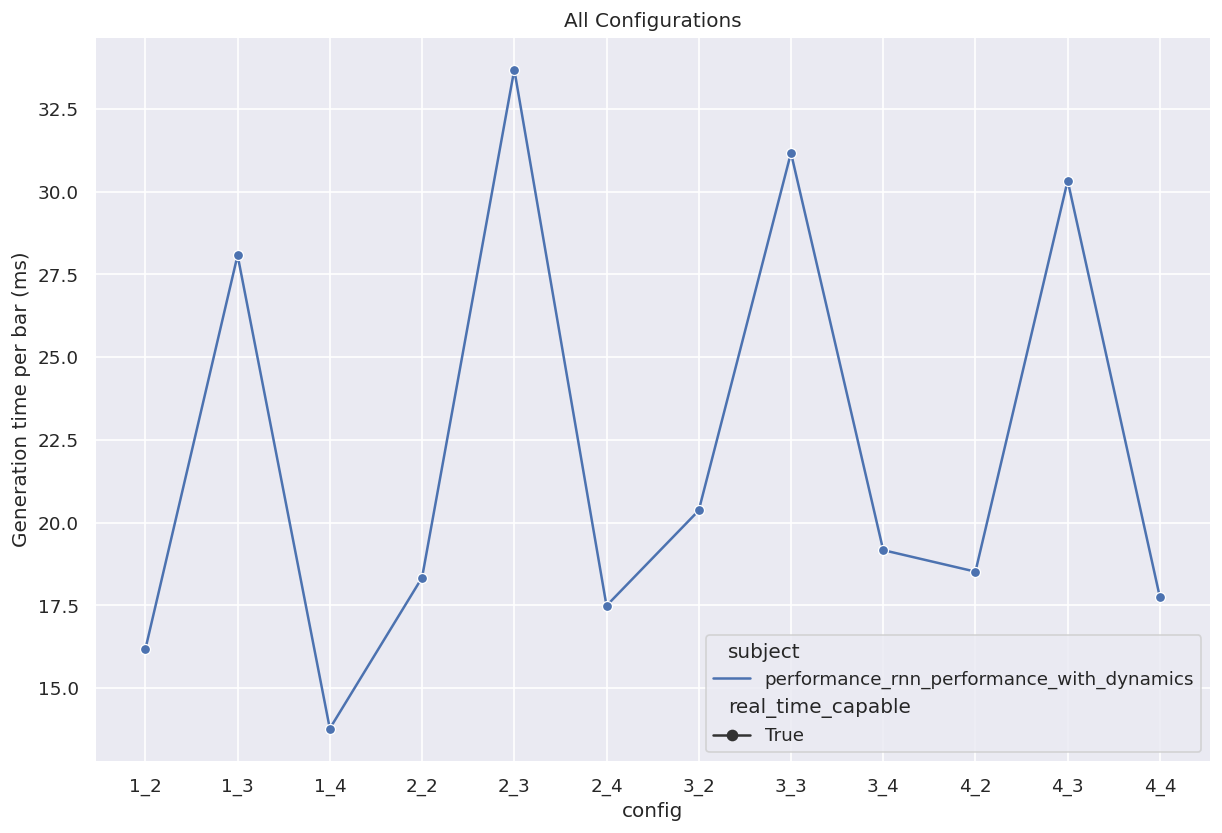

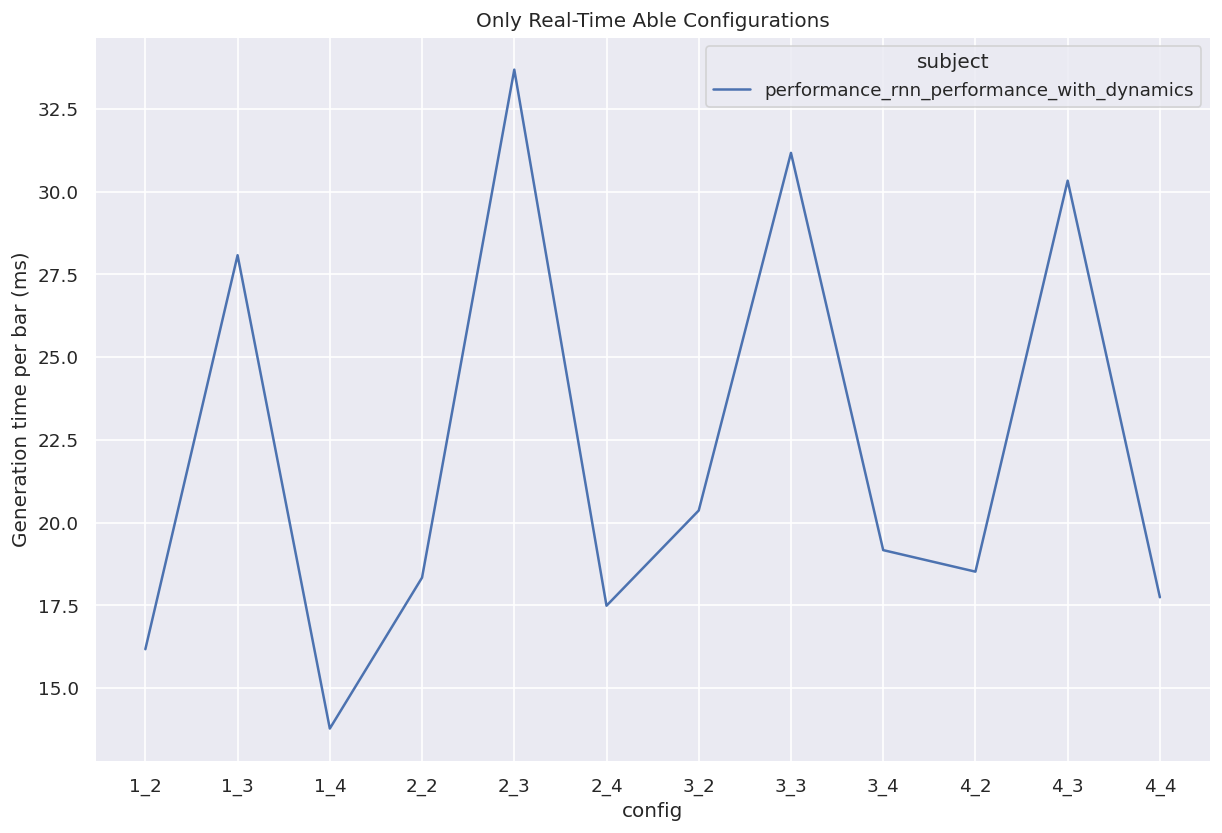

In [20]:

recalc = True
filter_bpm = True

if recalc and 'real_time_capable' in df_mean_metrics.columns:
    df_mean_metrics = df_mean_metrics.drop(columns=['real_time_capable'])

# Clear df_mean_metrics if re-running
df_mean_metrics = df_mean_metrics.drop(columns=[col for col in df_mean_metrics if col.startswith('subject')])

# Read features extracted from dataset
df_time = pd.read_pickle(output('df_dataset_features'))
df_time = df.groupby('dataset').mean().reset_index()
df_time = df_time.rename(columns={'bpm': 'mean_bpm', 'ticks': 'mean_ticks'})

# Read generation metrics
df_gen = pd.read_pickle(output('df_metrics_generation'))
df_time = df_gen.merge(df_time, how='inner', on=['dataset'])

# How to calculate this? (iterations * max_primers)
samples_per_request = 1
samples_per_request = iterations * max_primers
print(samples_per_request)

# Calculate time values
df_time['time'] /= samples_per_request
df_time['bar_duration_ms'] = 4 * (60000 / df_time['mean_bpm'])
df_time['bar_generation_ms'] = 1000 * df_time['time']
# 60000 / BPM = one beat in milliseconds

df_time = df_time.groupby(['model', 'checkpoint', 'in_len', 'out_len']).mean()
df_time = df_time.reset_index()

# Determine if a model is real-time capable
df_time['real_time_capable'] = df_time['bar_generation_ms'] < df_time['bar_duration_ms']
df_time['real_time_capable'] = df_time['real_time_capable'].astype(str)

# Plot generation time
df_time['config'] = df_time["in_len"].astype(str) + '_' + df_time["out_len"].astype(str)
df_time['subject'] = df_time["model"].astype(str) + '_' + df_time["checkpoint"].astype(str)

# Lineplot: All configurations
tmp_df = df_mean_metrics.merge(df_time[['model','checkpoint','config','real_time_capable', 'subject']], on=['model', 'checkpoint', 'config'])
fig = plt.figure(figsize=(12,8), dpi=120)
g = sns.lineplot(data=tmp_df, y='time', x='config', hue='subject', err_style="bars", ci=68, markers=True, dashes=False, style="real_time_capable")
plt.title('All Configurations')
g.set_ylabel('Generation time per bar (ms)')
plt.savefig(figure_output('lineplot_all_configurations'))

# Filter configuration - select those those that can be used in real time
if 'real_time_capable' not in df_mean_metrics.columns and filter_bpm:
    # print(tmp_df.groupby('real_time_capable').head())
    df_mean_metrics = tmp_df.loc[tmp_df['real_time_capable'] == 'True']

# Lineplot: Selected Configurations
sns.set_theme(style='darkgrid')
fig = plt.figure(figsize=(12,8), dpi=120)
g = sns.lineplot(data=df_mean_metrics, y='time', x='config', hue="subject", err_style="bars", ci=68, markers=True, dashes=False)
plt.title('Only Real-Time Able Configurations')
g.set_ylabel('Generation time per bar (ms)')
plt.savefig(figure_output('lineplot_selected_configurations'))

tmp_df = df_time[['subject', 'time', 'in_len', 'out_len', 'bar_duration_ms', 'bar_generation_ms', 'mean_bpm']]
tmp_df.head()
# tmp_df.groupby(['subject', 'out_len']).mean()

<Figure size 432x288 with 0 Axes>

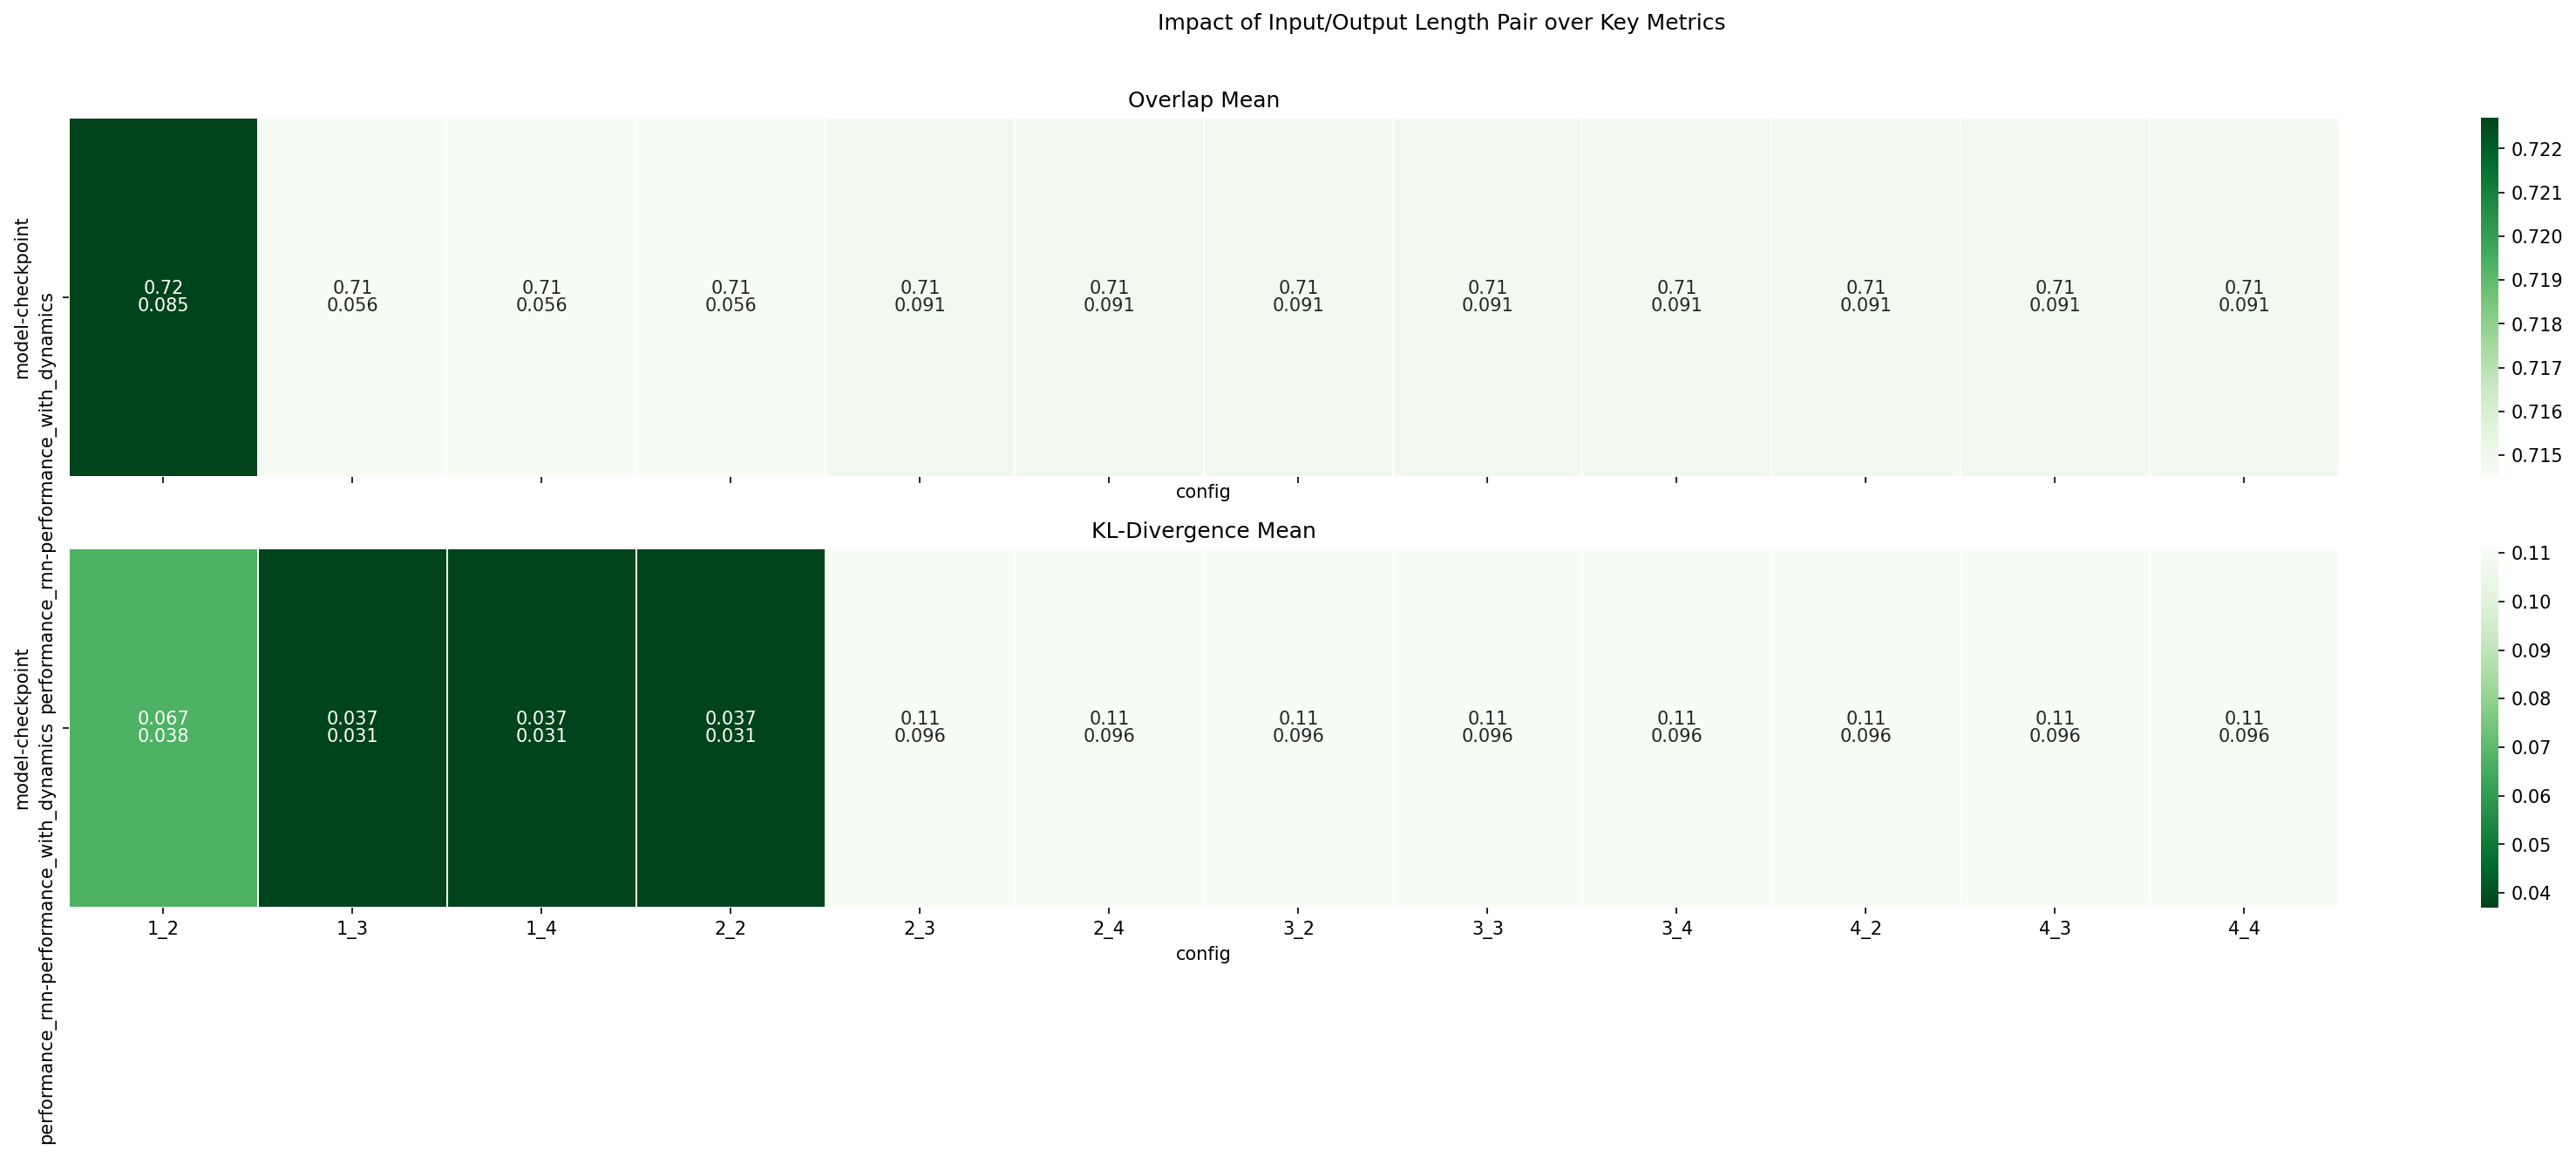

In [14]:


if 'heatmap_metrics_per_model_config' in plots_to_make or True:
    tmp_df = df_mean_metrics.copy()
    subplots = (
        [ ('overlap_mean', 'overlap_std', 'Overlap Mean')
        , ('kl_mean'     , 'kl_std'     , 'KL-Divergence Mean')
        ]
    )

    # Process Average/STDs
    subplots = [(pd.pivot_table(tmp_df, values=column_mean, index=['model', 'checkpoint'], columns=['config'])
        , pd.pivot_table(tmp_df, values=column_std, index=['model', 'checkpoint'], columns=['config'])
        , title
        )
        for (column_mean, column_std, title)
        in subplots]

    # Make Heatmaps
    plt.figure()
    fig, axs = plt.subplots(2, figsize=(28,8), sharex='col', sharey='row', dpi=150)
    fig.suptitle('Impact of Input/Output Length Pair over Key Metrics')
    gs = fig.add_gridspec(2, 1, hspace=0, wspace=0)
    for i, (mean_df, std_df, title) in enumerate(subplots):
        cmap = ['Greens', 'Greens_r'][i]

        ax = axs[i]
        ax.set_title(title)
        sns.heatmap(mean_df, annot=mean_df,   cmap=cmap, linewidths=0.5, ax=ax, annot_kws={'va':'bottom'})
        sns.heatmap(mean_df, annot=std_df, cmap=cmap, linewidths=0.5, ax=ax, annot_kws={'va':'top'}, cbar=False)

    # plt.savefig('output/images/metric_mean_std_config_heatmap.png')
    plt.show()

### Heatmap + Cat Plot: Metrics per Best Model Configuration

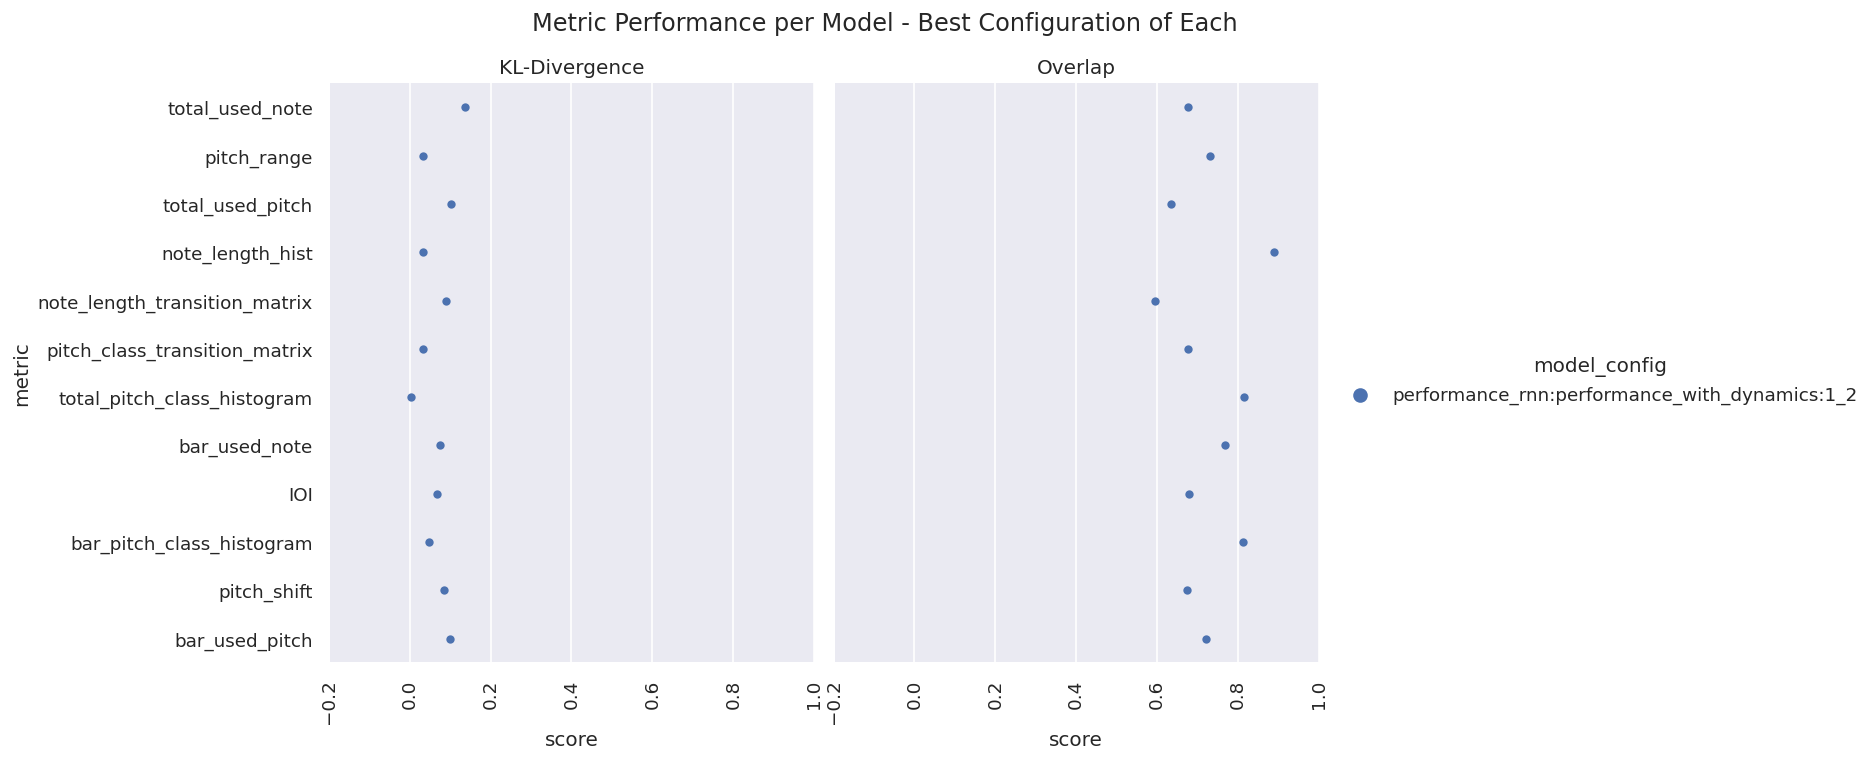

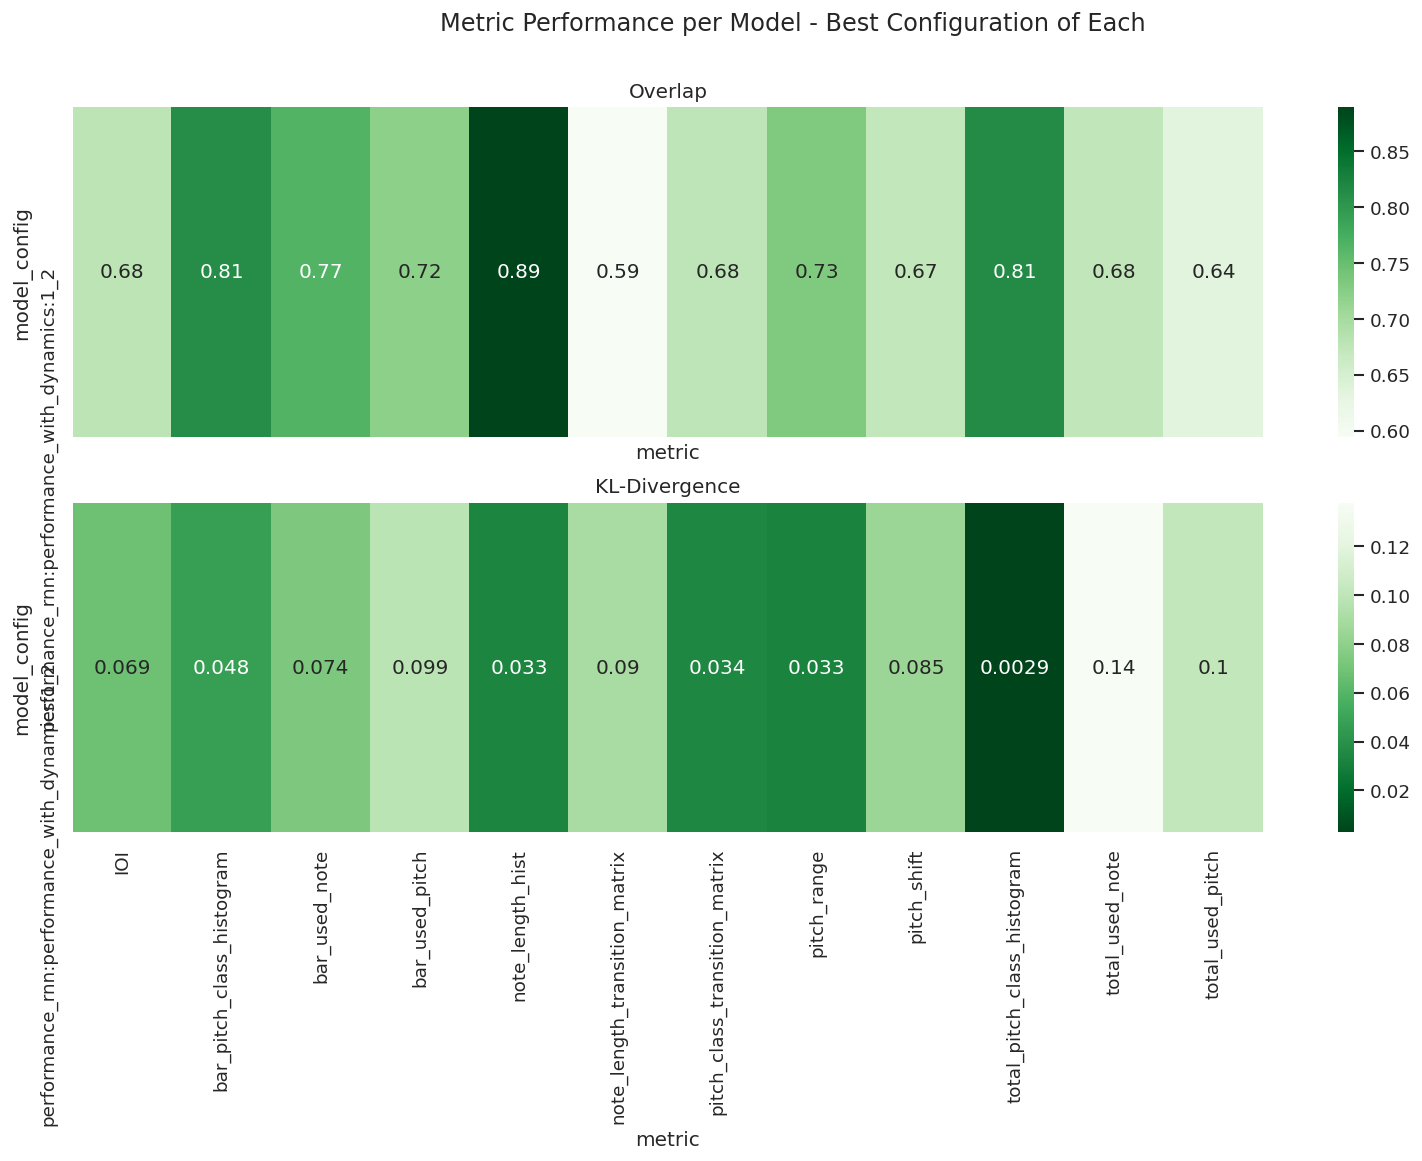

In [15]:
# Best Config per Model:Checkpoint

# IMPORTANT:
# Determine best configuration for each model:checkpoint
maxes = df_mean_metrics.loc[df_mean_metrics.reset_index().groupby(['model','checkpoint'])['overlap_mean'].idxmax()]
maxes['seconds_per_bar'] = maxes['time'] / maxes['out_len'] / 10
cols = ['model', 'checkpoint', 'config']
maxes['model_config'] = maxes[cols].apply(lambda row: ':'.join(row.values.astype(str)), axis=1)
maxes = maxes.drop(columns=['model','checkpoint','config','in_len','iteration'])
maxes.set_index('model_config', drop=True)

subplots = (
    [ ('_overlap', 'Best Model Configuration: Metric Overlap against Dataset')
    , ('_kl_div', 'Best Model Configuration: Metric KL-Divergence against Dataset')
    ]
)

# Convert DataFrame to Long-Form, splitting by metric type (Overlap / KL-Divergence)
metrics = [metric for metric in maxes.columns for (suffix,_) in subplots if metric.endswith(suffix)]
maxes = maxes[['model_config'] + metrics]
maxes = maxes.melt(id_vars=["model_config"], var_name="metric", value_name="score").dropna()
maxes['metric_type'] = maxes['metric'].astype(str).str.contains(subplots[0][0]).apply(lambda x: 'Overlap' if x == True else 'KL-Divergence')
maxes['metric'] = filter_metric_names(maxes['metric'])

# Best Config of Each - Scatter Plot
sns.set_theme(style="darkgrid")
g = sns.catplot(data=maxes, y="metric", x="score", hue="model_config", col='metric_type',  kind="swarm", height=6, aspect=1,
order=maxes.metric.value_counts().index)
locs, labels = plt.xticks()
g.set_xticklabels(labels, rotation=90)
g.set_titles('{col_name}')
g.fig.suptitle('Metric Performance per Model - Best Configuration of Each')
g.fig.subplots_adjust(top=0.88)
g.fig.set_dpi(120)
plt.savefig(figure_output('best-config-of-each-scatter-plot'))
plt.show()

# Best Config of Each - Heatmaps
fig, axs = plt.subplots(2, figsize=(16,8), sharex='col', sharey='row', dpi=120)
fig.suptitle('Metric Performance per Model - Best Configuration of Each')
gs = fig.add_gridspec(2, 1, hspace=0, wspace=0)
for i, metric_type in enumerate(reversed(maxes['metric_type'].unique())):
    ax = axs[i]
    ax.set_title(f'{metric_type}')
    cmap = ['Greens', 'Greens_r'][i]
    tmp_df = maxes.groupby('metric_type').get_group(metric_type)
    tmp_df = pd.pivot_table(tmp_df, values='score', index=['model_config'], columns=['metric'])
    sns.heatmap(data=tmp_df, ax=axs[i], annot=True, cmap=cmap)
plt.savefig(figure_output('best-config-of-each-heatmap'))
plt.show()

### Point Plot: Metric Overlap x Subject Configuration

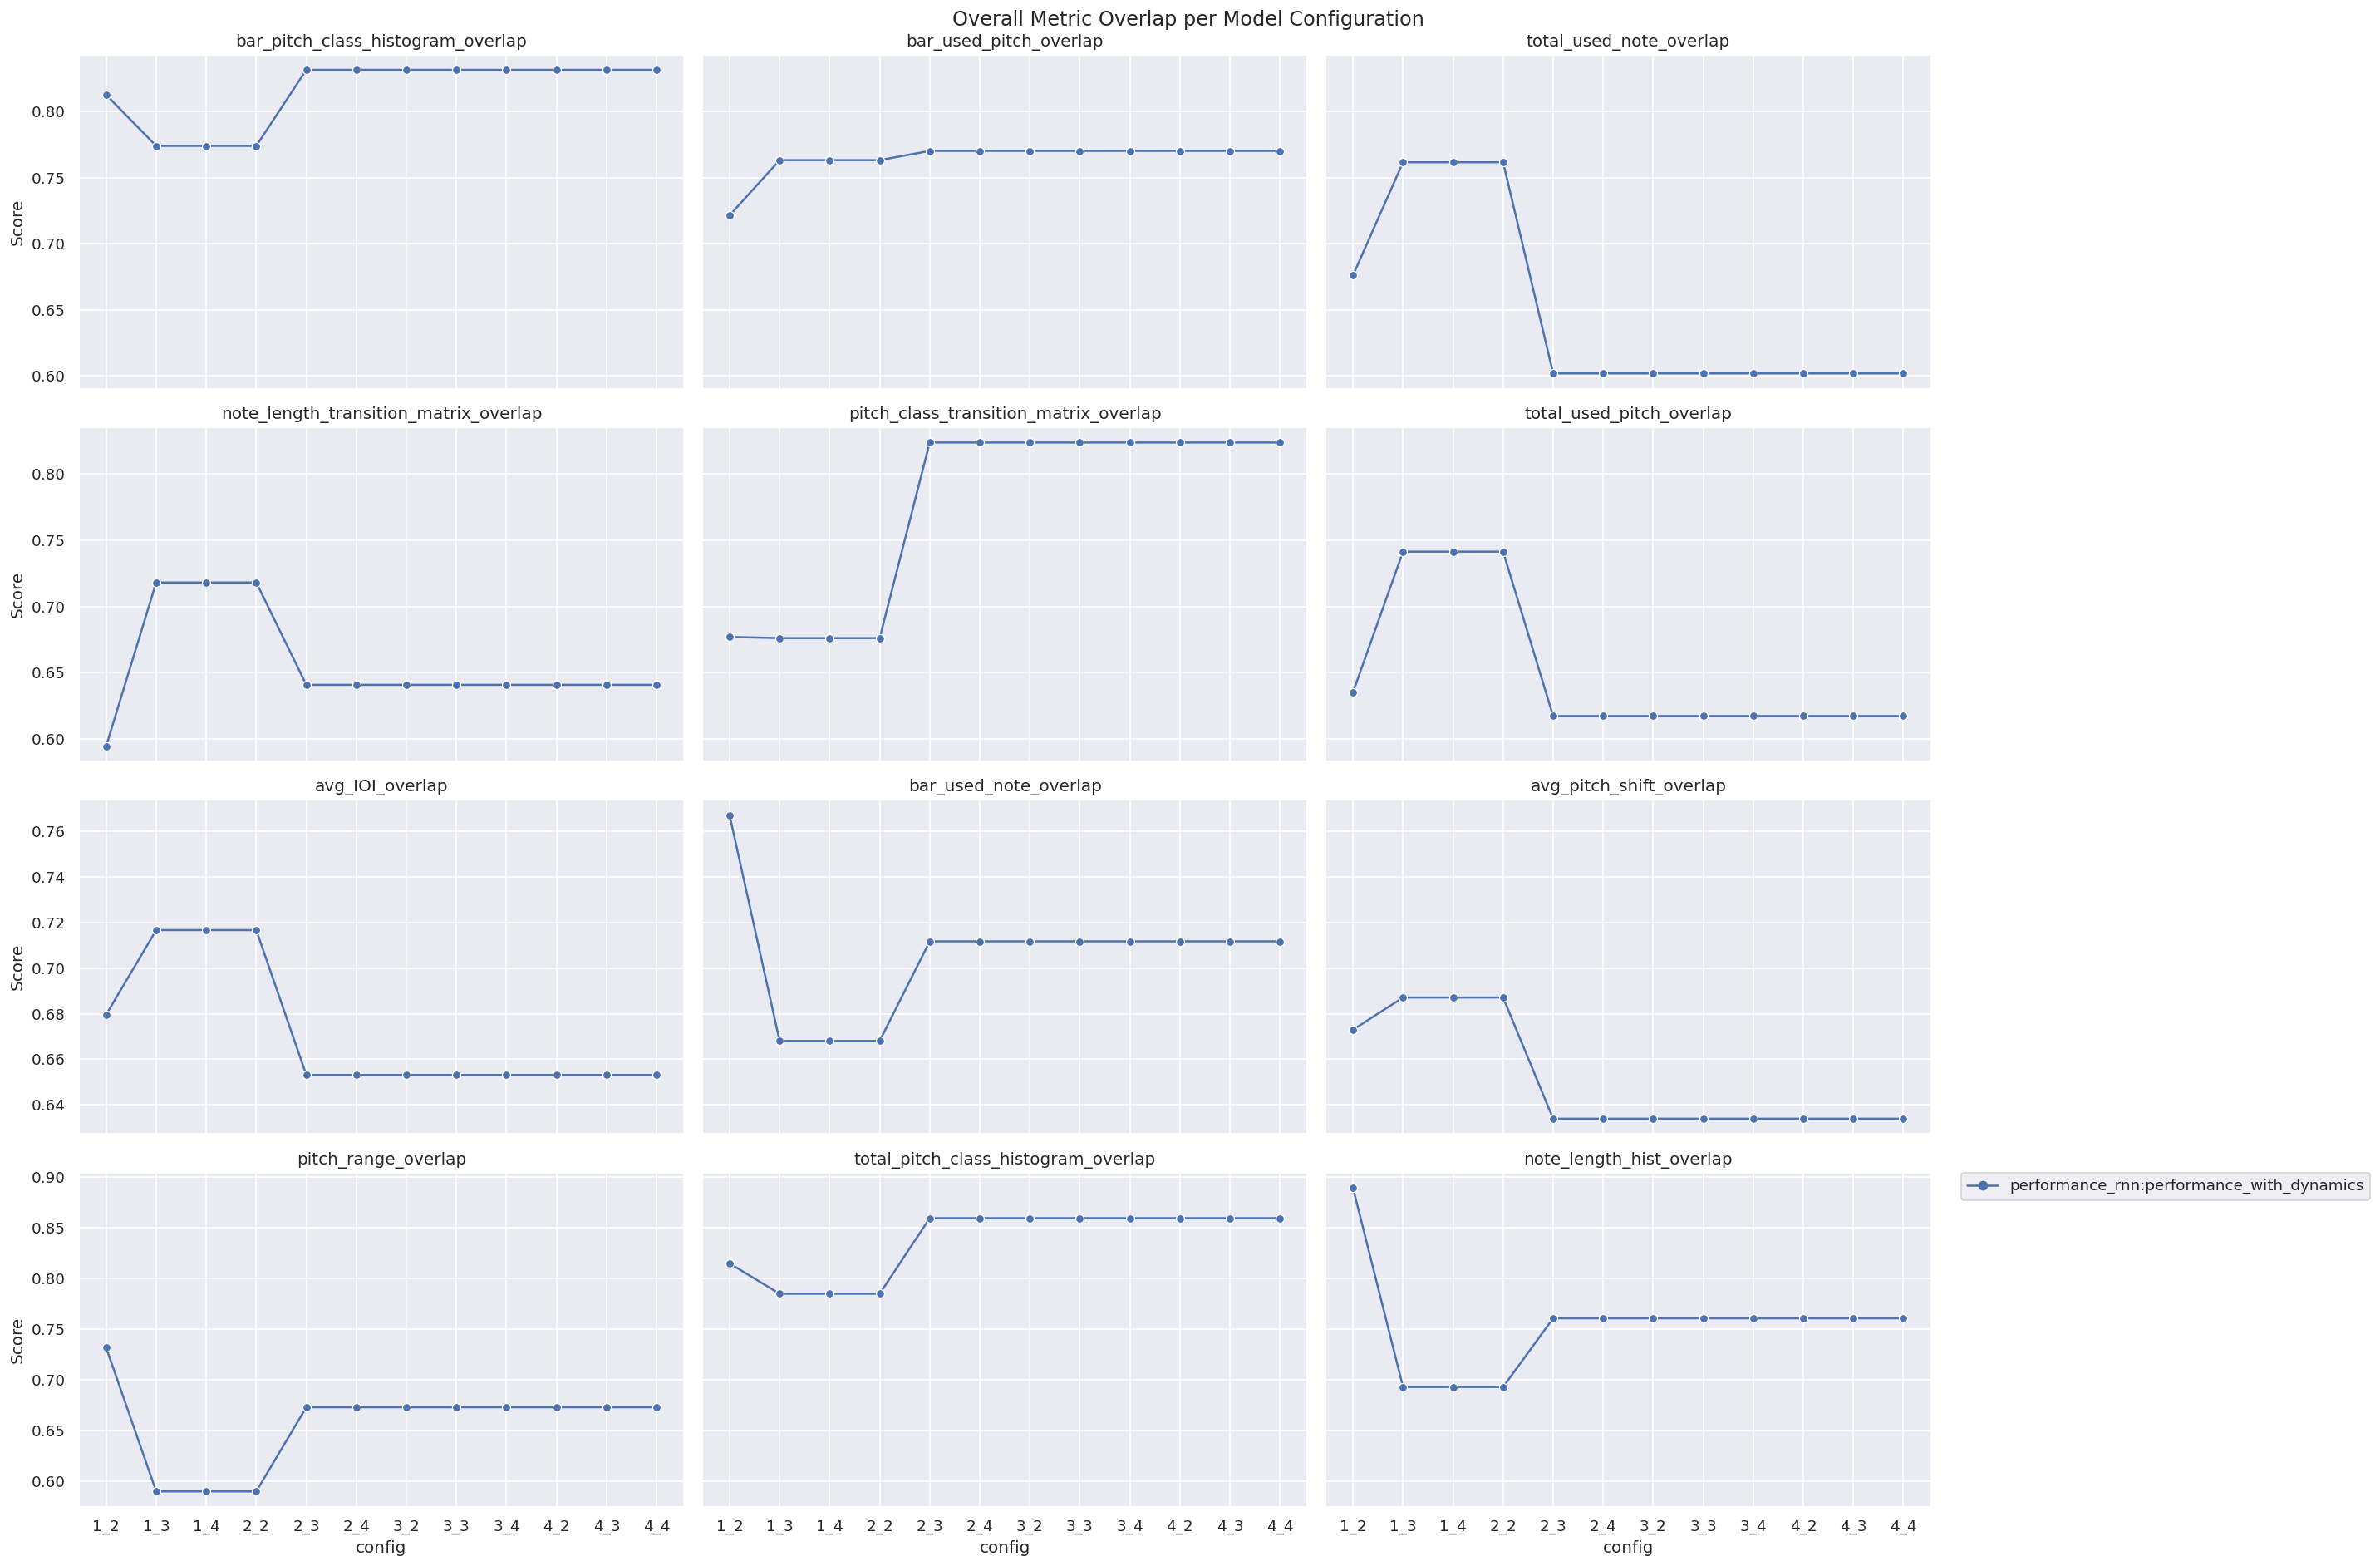

In [16]:
# Initialize DF
tmp_df = df_mean_metrics.copy()
tmp_df['subject'] = tmp_df[['model', 'checkpoint']].apply(lambda row: ':'.join(row.values.astype(str)), axis=1)

# Define which metrics to plot and subplot arrangement
overlaps = [m for m in metrics if m.endswith('_overlap')]
col_count = 3
row_count = math.ceil(len(overlaps) / col_count)


# Make Plots
fig, axs = plt.subplots(row_count, col_count, figsize=(24,16), sharex='col', sharey='row', dpi=120)
sns.set_theme(style="darkgrid")

for i, plotcol in enumerate(overlaps):
    data = tmp_df[['subject', 'config', 'time', plotcol]]
    data = data.drop(columns='time')
    
    # Generate Plot
    locs, labels = plt.xticks()

    sns.set_theme(style="darkgrid")
    ax = axs[math.floor(i/col_count), i % col_count]

# fig = plt.figure(figsize=(12,8), dpi=120)
    sns.lineplot(
        data=tmp_df, y=plotcol, x="config", hue="subject", err_style="bars", ci=68
        , markers=True, dashes=False, style="subject", ax=ax
    )
    ax.set_title(plotcol)
    ax.get_legend().remove()
    ax.set_ylabel('Score')


handles, labels = ax.get_legend_handles_labels()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.suptitle("Overall Metric Overlap per Model Configuration")
plt.tight_layout()
plt.savefig(figure_output('best-config-mean-metrics-lineplot'))
plt.show()


### Point Plot: Best Config vs Baseline per Model

No handles with labels found to put in legend.


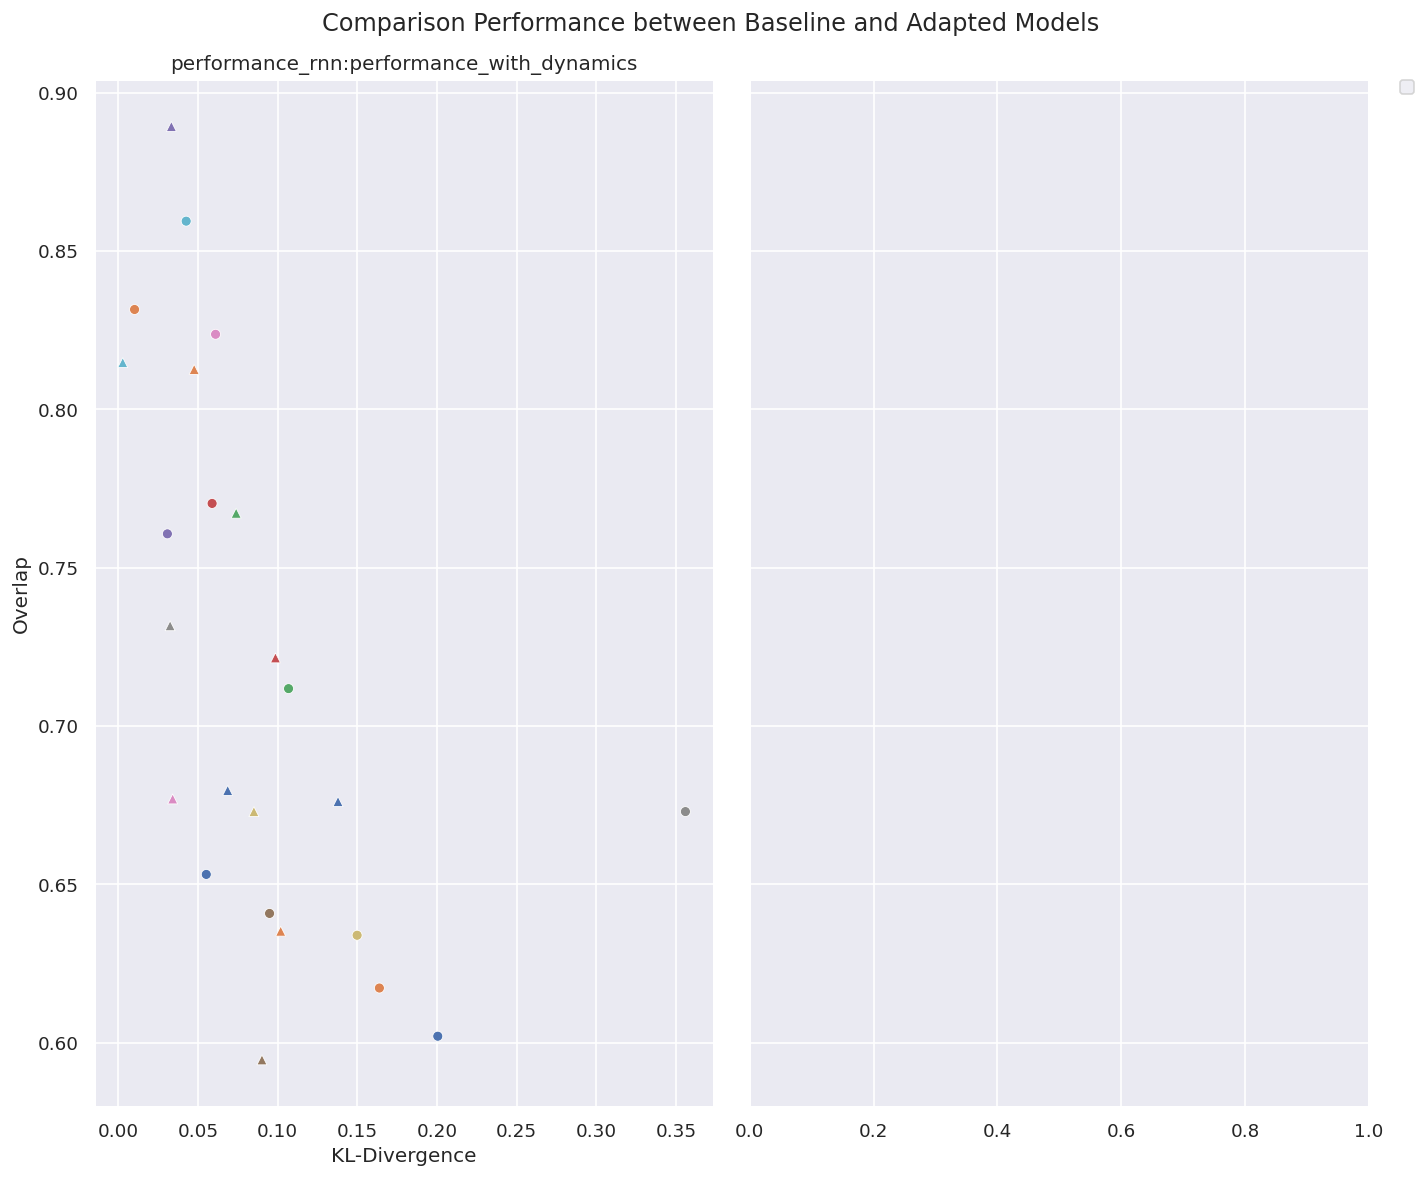

In [19]:
df_baseline = pd.read_pickle('output/df_metrics_baseline')

# Prepare "best configs" dataframe to receive baselines
df_comp = maxes.copy()
df_comp['config'] = df_comp['model_config'].apply(lambda config: config.split(':')[-1])
df_comp['subject'] = df_comp['model_config'].apply(lambda config: ':'.join(config.split(':')[:-1]))
df_comp = df_comp.drop(columns=['model_config'])

df_baseline['subject'] = df_baseline['model'] + ':' + df_baseline['checkpoint']
df_baseline = df_baseline.drop(columns=['model','checkpoint','dataset'])

df_baseline = df_baseline.melt(id_vars=["subject"], var_name="metric", value_name="score").dropna()
df_baseline['metric_type'] = df_baseline['metric'].astype(str).str.contains('_overlap').apply(lambda x: 'Overlap' if x == True else 'KL-Divergence')
df_baseline['metric'] = filter_metric_names(df_baseline['metric'])


df_comp_bk = df_comp.copy()
df_comp = df_comp.merge(df_baseline, how='inner', on=['subject', 'metric', 'metric_type'], suffixes=("_gen", "_baseline"))

# Split baseline/generated sample scores
df_comp = df_comp.melt(id_vars=["subject", "metric", "metric_type", "config"], var_name="source", value_name="score").dropna()

# Split metric scores by type (KL-Divergence / Overlap)
df_comp = df_comp.pivot_table(index=['subject','metric', 'source', 'config'], columns='metric_type')
df_comp.columns = df_comp.columns.droplevel().rename(None)
df_comp['KL-Divergence'] = df_comp['KL-Divergence'].astype(float)
df_comp['Overlap'] = df_comp['Overlap'].astype(float)
df_comp = df_comp.reset_index()

# Rename sample sources
for oldname, newname in [('score_baseline', 'Baseline'), ('score_gen', "Generated Samples")]:
    df_comp.loc[df_comp['source'] == oldname, 'source'] = newname

# Figure out subplot dimensions
col_count = 2
subjects = df_comp['subject'].unique()
row_count = math.ceil(len(subjects) / col_count)
fig, axs = plt.subplots(row_count, col_count, figsize=(12,10), sharex='col', sharey='row', dpi=120)
# fig = plt.figure(figsize=(12,8), dpi=120)
fig.suptitle('Comparison Performance between Baseline and Adapted Models')
fig.add_gridspec(col_count, row_count, hspace=0, wspace=0)

# FIXME
for i, subject in enumerate(df_comp.groupby('subject').groups):
    # Filter data relative to subject
    data = df_comp.loc[df_comp['subject'] == subject]
    
    # Generate Plot
    locs, labels = plt.xticks()

    sns.set_theme(style="darkgrid")
    ax = axs[math.floor(i/col_count), i % col_count] if row_count > 1 else axs[i]
    ax = sns.scatterplot(x="KL-Divergence", y="Overlap", hue="metric", style="source", data=data, ax=ax, palette="deep", markers=['o','^'])
    ax.set_title(subject)
    ax.get_legend().remove()

handles, labels = ax.get_legend_handles_labels()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.savefig(figure_output('best-config-against-baseline'))
plt.show()


## Qualitative Analysis

In [22]:
# 1. Prepare dataset

import shutil
import pathlib
qa_sampledir = output('qualitative_analysis')

# 2. Randomly sample
df_samples = pd.read_pickle(output('df_gen'))
df_samples = df_samples.sample(4,random_state=0).reset_index()
df_samples['samplename'] = 'audio_' + df_samples.index.astype(str)



# Copy files
if os.path.exists(qa_sampledir): shutil.rmtree(qa_sampledir)
pathlib.Path(qa_sampledir).mkdir(parents=True, exist_ok=True)


cmd_convert = lambda _input, _output: ['bash', '-c', f'timidity {_input} -Ow -o - | ffmpeg -y -f wav -i - "{_output}.mp3"']

t = tqdm(df_samples[['out_file_prep', 'samplename']].values)
for genfile, samplefile in t:
    # shutil.copyfile(output(genfile), output(f'qualitative_analysis/{samplefile}'))
    cmd = cmd_convert(output('preprocessed', 'generation', genfile), output('qualitative_analysis', samplefile))
    t.set_description(' '.join(cmd))
    subprocess.call(cmd)
    

bash -c timidity /home/ghales/git/tg-server/output/preprocessed/generation/performance_rnn:performance_with_dynamics:3:4:clean_piano-e-comp:8:2021-08-27-2/performance_rnn-performance_with_dynamics-4-3-4-MIDI-Unprocessed_03_R1_2008_01-04_ORIG_MID--AUDIO_03_R1_2008_wav--1.midi -Ow -o - | ffmpeg -y -f wav -i - "/home/ghales/git/tg-server/output/qualitative_analysis/audio_3.mp3": 100%|██████████| 4/4 [00:00<00:00,  7.55it/s]


# Debug
---

In [23]:
# def get_generation_command(the_modelname, the_checkpointname, output_tracks, datapath, primer, bars_input, bars_output, count)

# primer_length -= 1
# sample_length = 4

print(f'max_input_bars: {max_input_bars}')
print(f'max_output_bars: {max_output_bars}')
print(f'sample_length: {sample_length}')
print(f'primer_length: {primer_length}\n')

a = get_generation_command('melody_rnn', 'attention_rnn', None, 'dataset', 'testprimer', 3, 3, 1)
print(a)



max_input_bars: 2
max_output_bars: 2
sample_length: 4
primer_length: 4

set\ debug_output\ True\;set\ batch_mode\ True\;set\ playback\ False\;set\ batch_unit\ measures\;set\ debug_output\ False\;set\ input_length\ 3\;set\ input_unit\ bars\;set\ output_length\ 3\;set\ output_unit\ bars\;reset\;load\ /dataset/testprimer\ 3\;generate\ 3\ bars\;generate\ 3\ bars\;drop_primer\;crop\ bars\ 0\ 7\;save\ 2021-08-26-16/melody_rnn-attention_rnn-0-3-3-testprimer\;end
